Collecting data from Yahoo Finance using yfinance library.

In [2]:
import yfinance as yf

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "^GSPC"]
start_date = "2020-01-01"
end_date = "2024-12-31"

data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in tickers}

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data Preprocessing

In [4]:
import pandas as pd
from ta.momentum import RSIIndicator
from sklearn.preprocessing import MinMaxScaler

def preprocess_stock_data(df):
    df = df.copy()

    # calculate moving average
    df['MA_20'] = df['Close'].rolling(window=20).mean()

    # ensure Close is 1D Series for RSIIndicator
    close_series = df['Close'].squeeze()
    if isinstance(close_series, pd.DataFrame):  # just in case
        close_series = close_series.iloc[:, 0]

    # compute RSI
    rsi = RSIIndicator(close=close_series, window=14, fillna=True).rsi()
    df['RSI'] = rsi

    # remove rows with NaN values
    df.dropna(inplace=True)

    # normalization using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
    scaled_df = pd.DataFrame(scaled_values, index=df.index, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

    # include technical indicators
    scaled_df['MA_20'] = df['MA_20'].values
    scaled_df['RSI'] = df['RSI'].values

    return scaled_df

# execute preprocessing in every ticker
preprocessed_data = {}
for ticker in tickers:
    df = data[ticker]
    try:
        preprocessed_data[ticker] = preprocess_stock_data(df)
        print(f"{ticker} preprocessing completed successfully.")
    except Exception as e:
        print(f"{ticker} error during preprocessing: {e}")

AAPL preprocessing completed successfully.
MSFT preprocessing completed successfully.
GOOGL preprocessing completed successfully.
AMZN preprocessing completed successfully.
TSLA preprocessing completed successfully.
^GSPC preprocessing completed successfully.


EDA


 EDA for AAPL


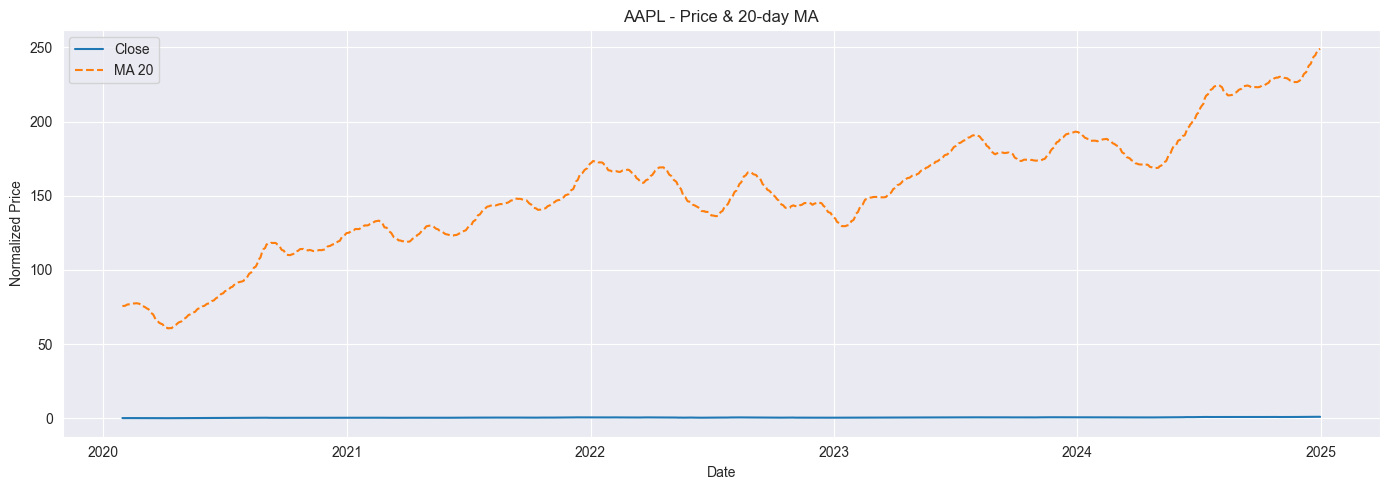

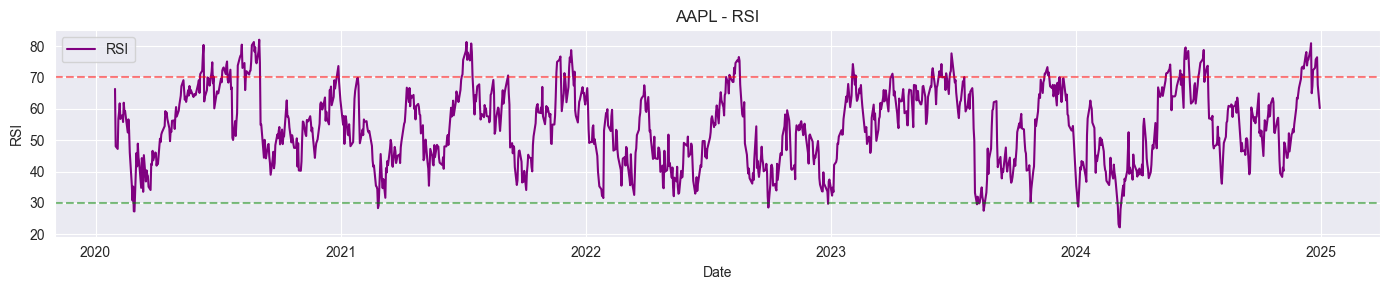

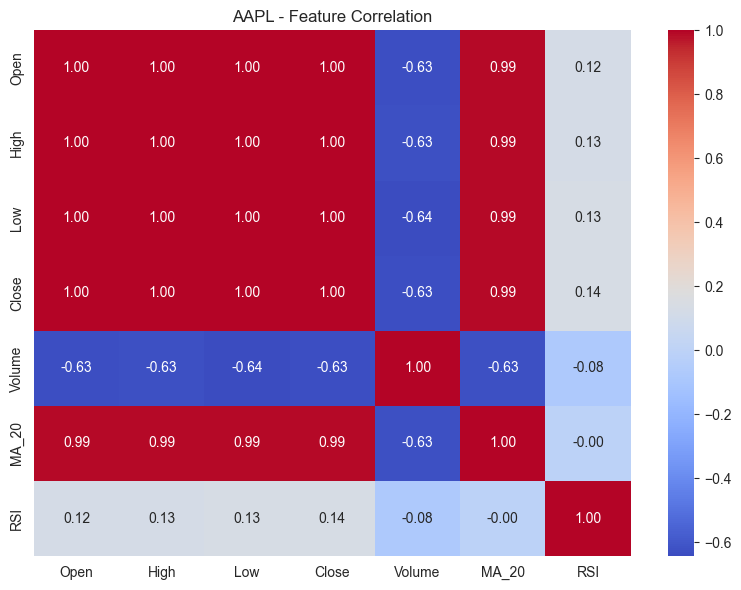

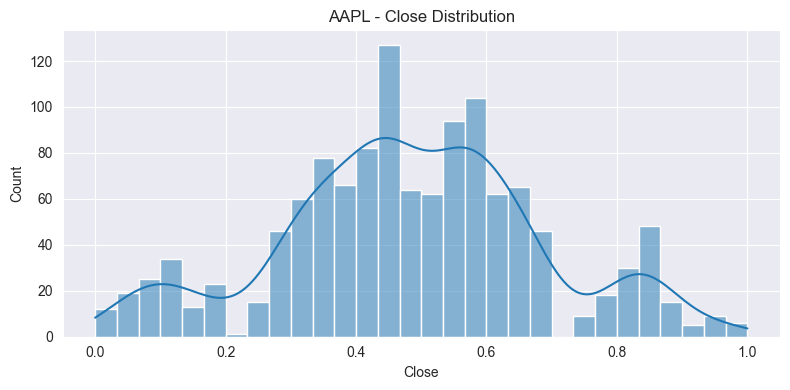


 EDA for MSFT


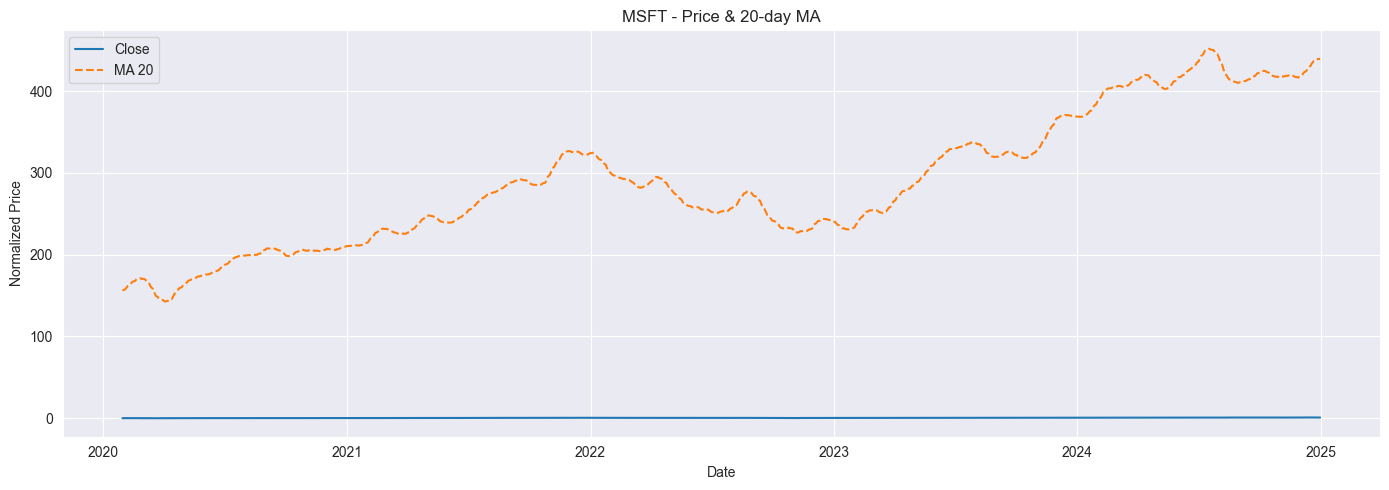

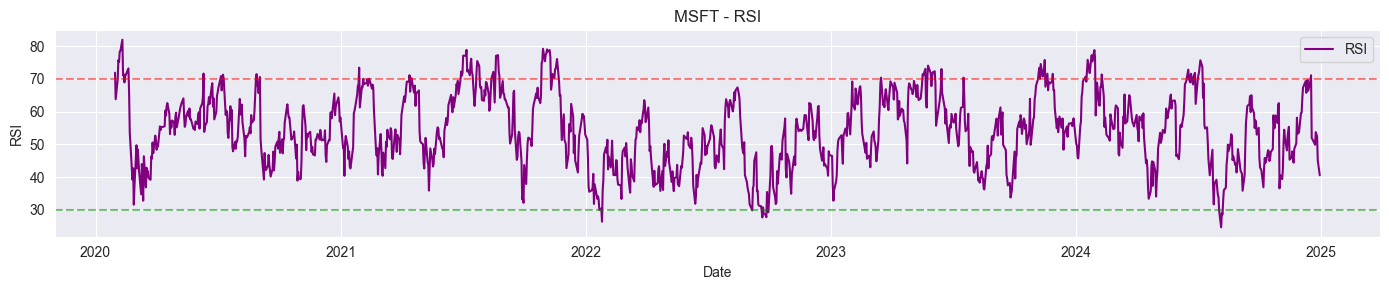

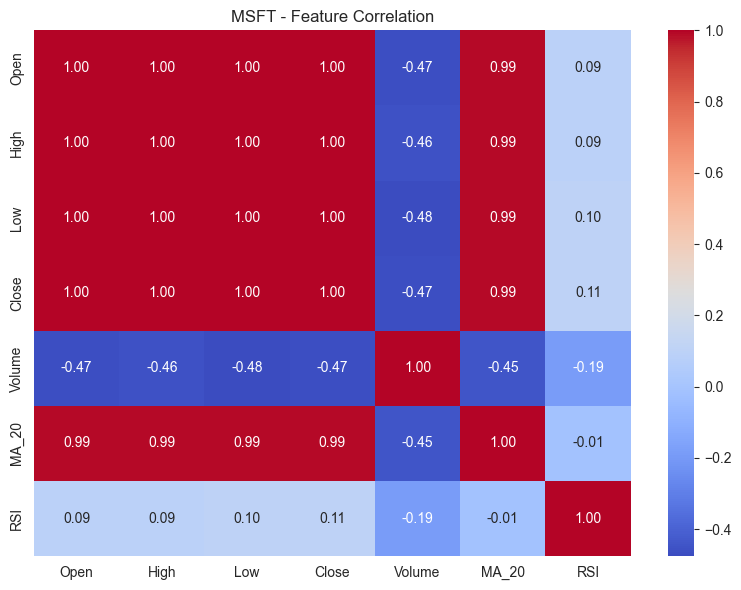

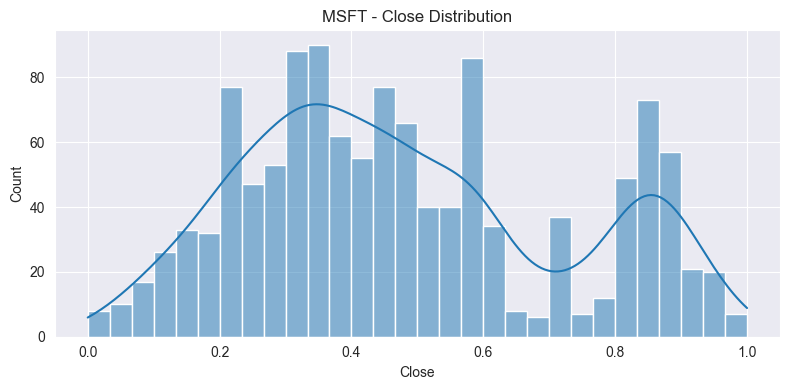


 EDA for GOOGL


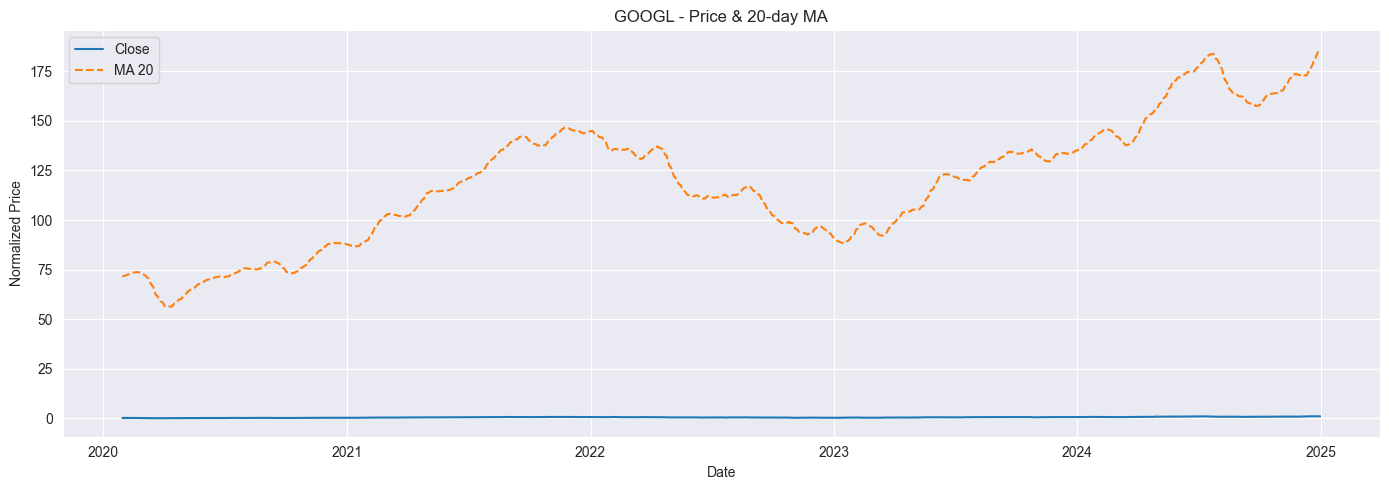

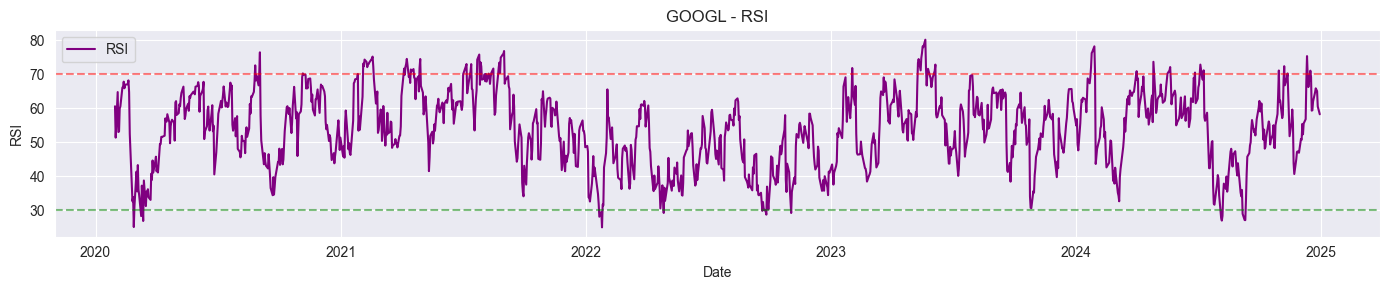

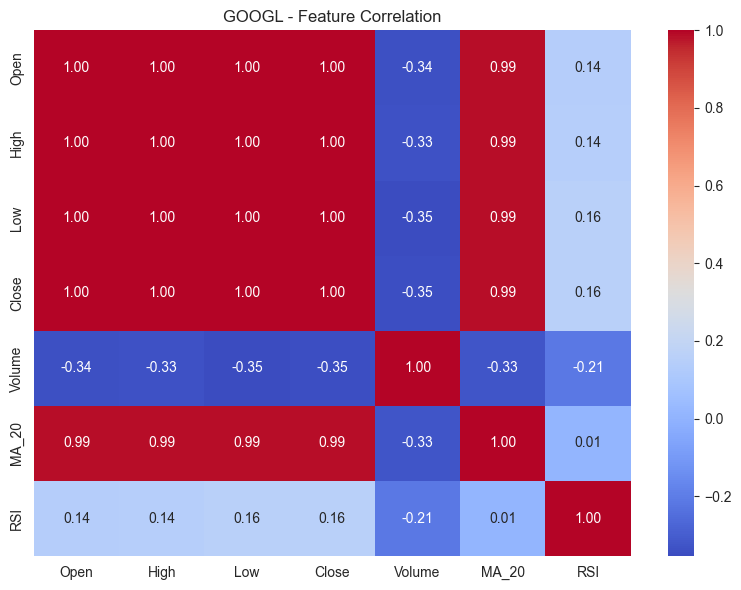

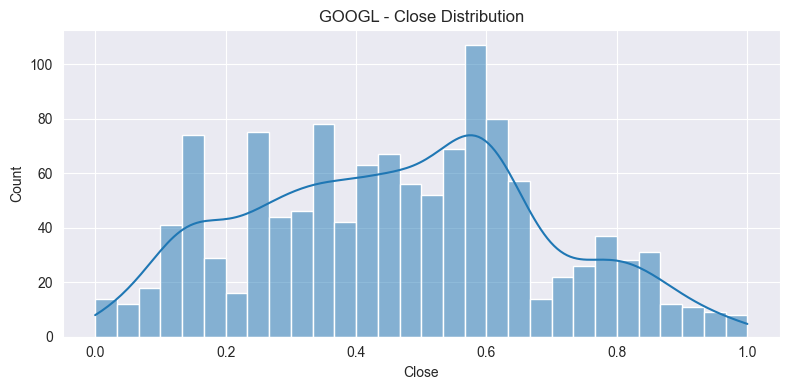


 EDA for AMZN


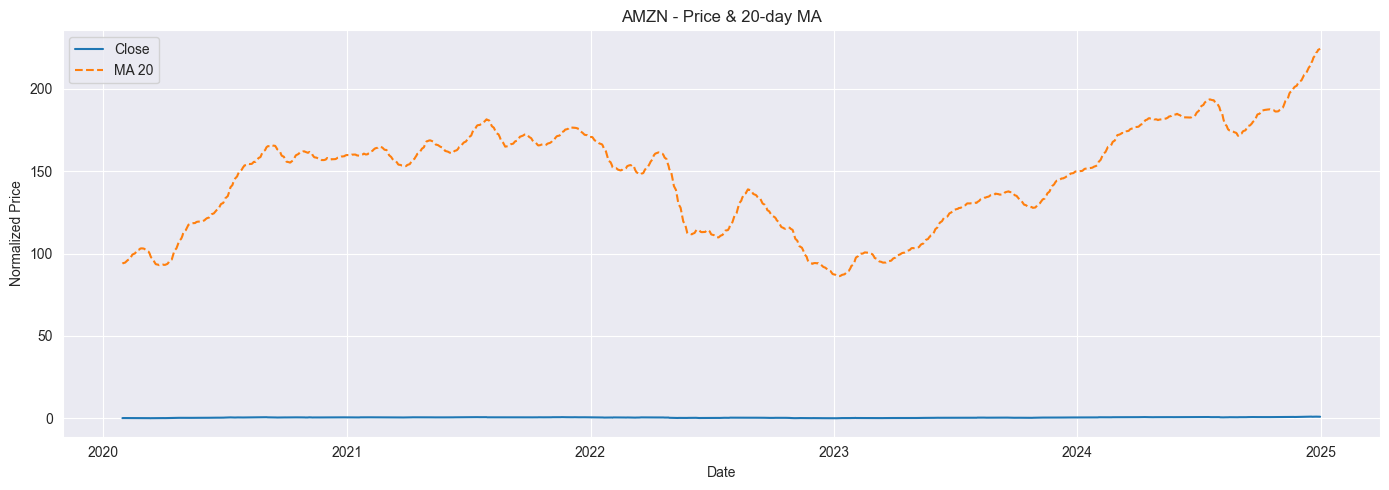

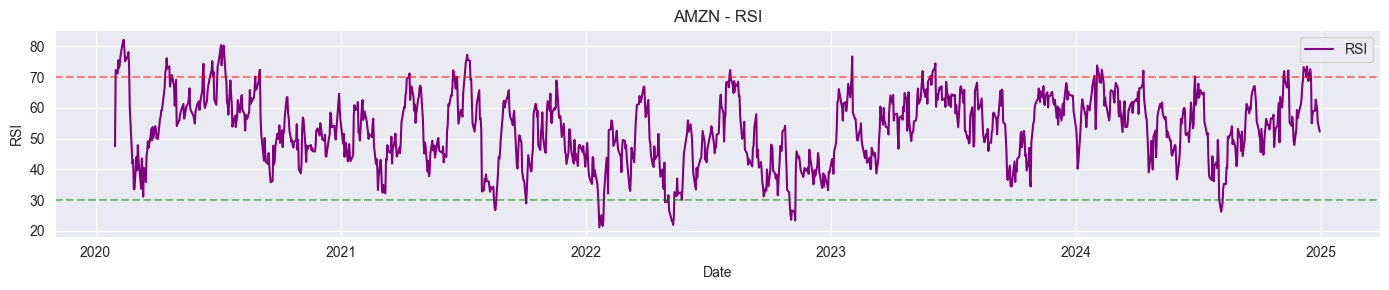

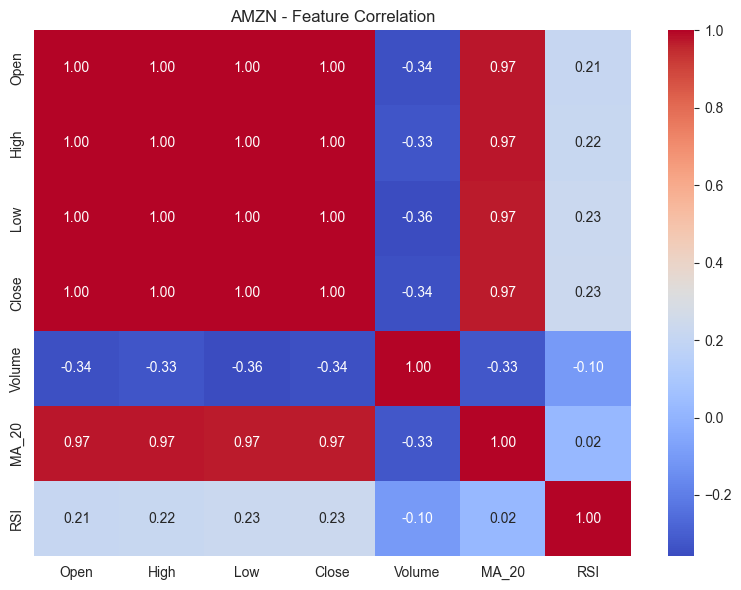

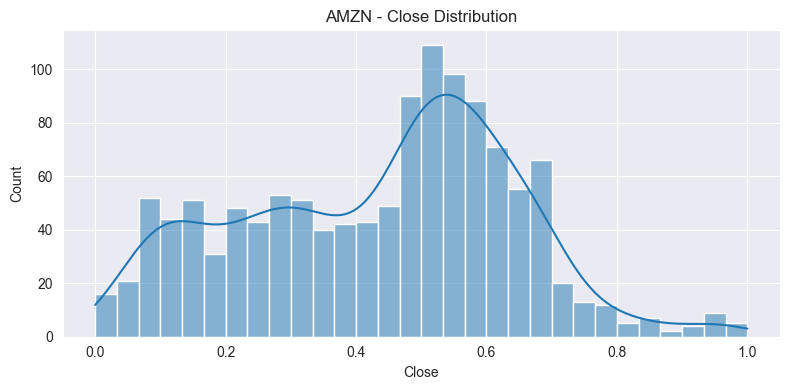


 EDA for TSLA


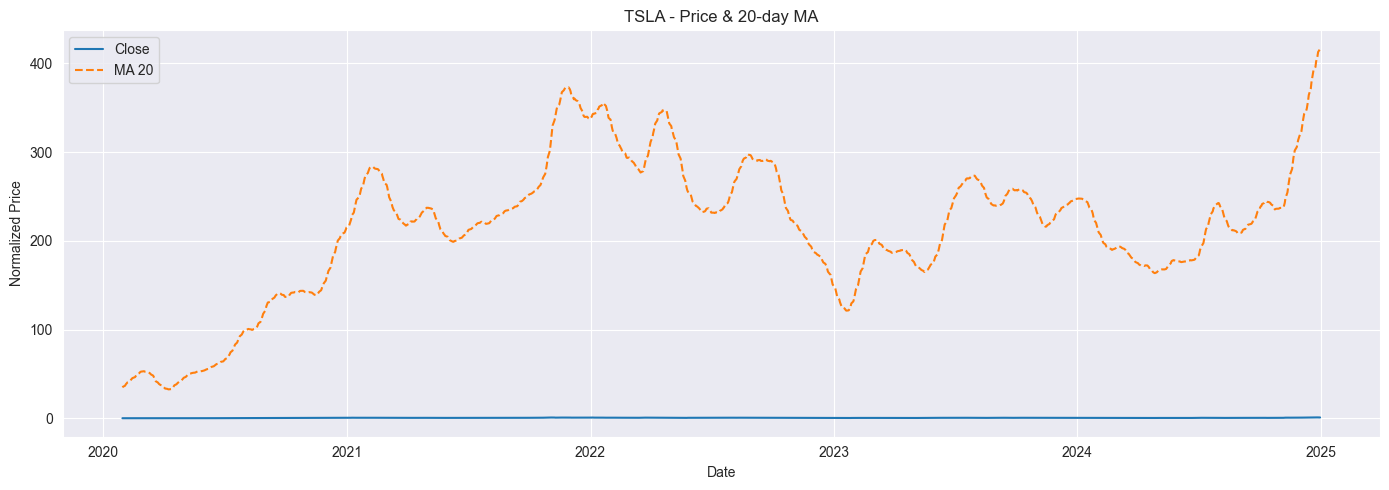

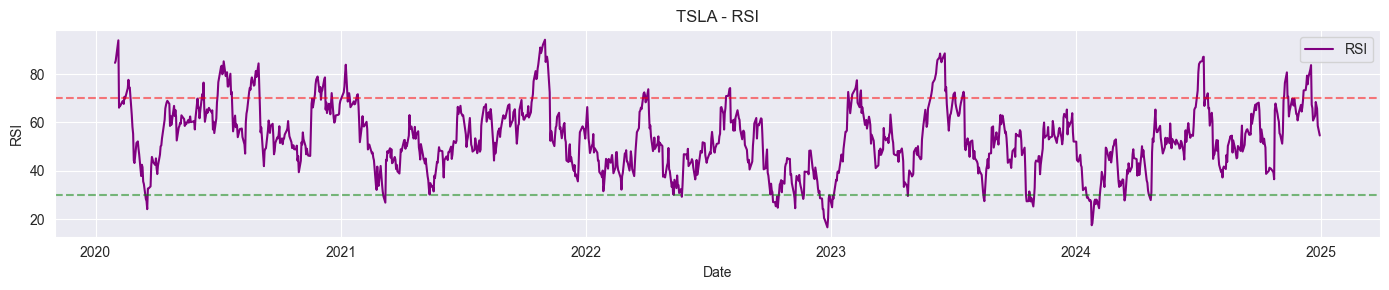

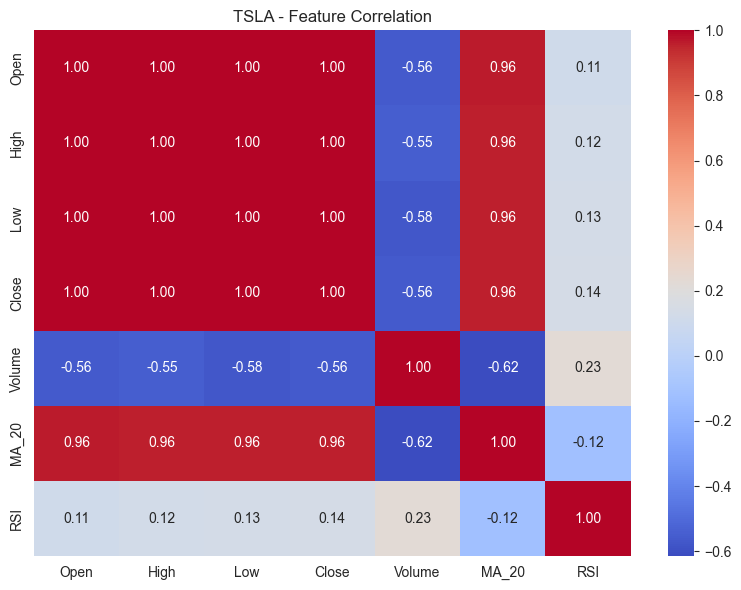

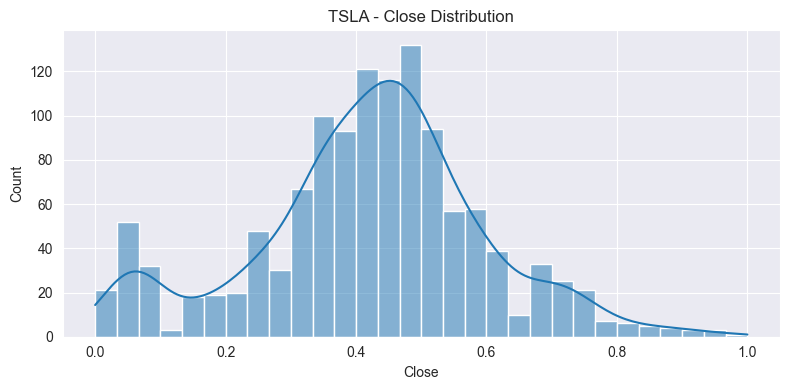


 EDA for ^GSPC


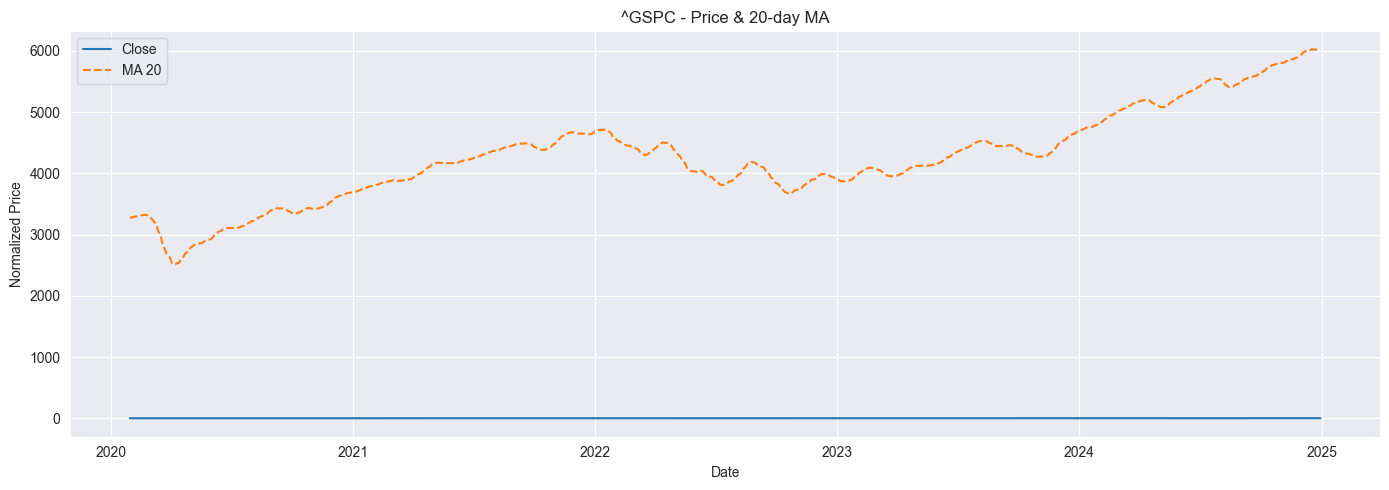

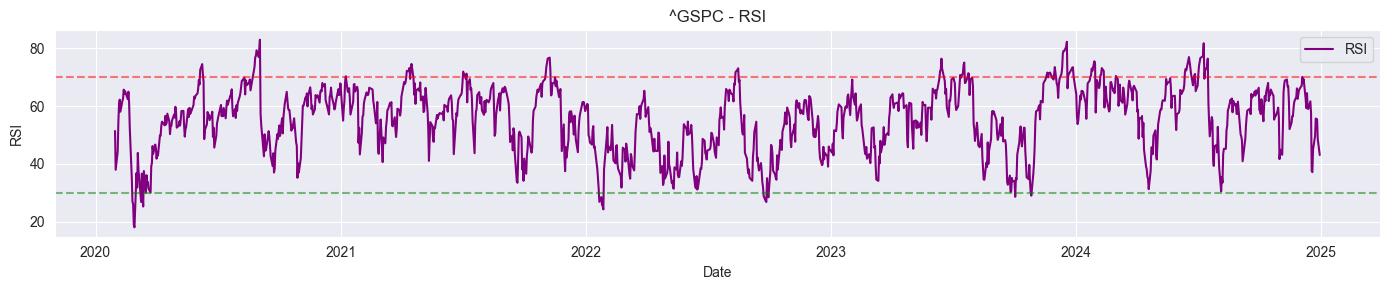

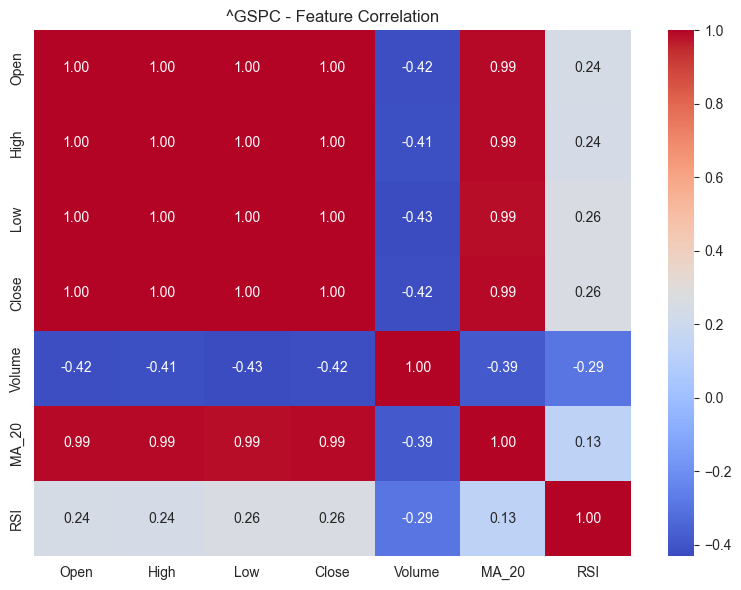

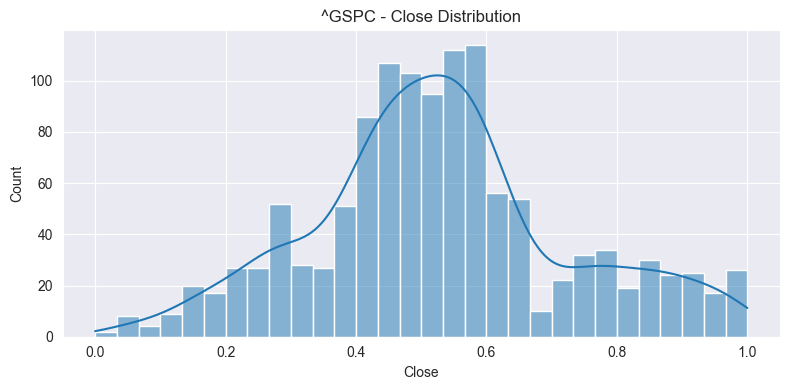

In [5]:
# Jupyter Notebook -- set graph output
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# visualize price tendency and average movement
def plot_price_trend(ticker, df):
    plt.figure(figsize=(14, 5))
    plt.plot(df['Close'], label='Close')
    plt.plot(df['MA_20'], label='MA 20', linestyle='--')
    plt.title(f"{ticker} - Price & 20-day MA")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# visualize RSI
def plot_rsi(ticker, df):
    plt.figure(figsize=(14, 3))
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', alpha=0.5)
    plt.axhline(30, color='green', linestyle='--', alpha=0.5)
    plt.title(f"{ticker} - RSI")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# correlation hitmap
def plot_correlation_heatmap(ticker, df):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{ticker} - Feature Correlation")
    plt.tight_layout()
    plt.show()

# distribution in increase analysis
def plot_distribution(ticker, df, column='Close'):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f"{ticker} - {column} Distribution")
    plt.xlabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ================================
# auto-execute EDA
# ================================
for ticker in tickers:
    print(f"\n EDA for {ticker}")
    try:
        df = preprocessed_data[ticker]
        plot_price_trend(ticker, df)
        plot_rsi(ticker, df)
        plot_correlation_heatmap(ticker, df)
        plot_distribution(ticker, df, column='Close')
    except Exception as e:
        print(f"{ticker} EDA error: {e}")

*** Linear Regression, Decision Tree, SVR, Random Forest Regressor ***
* includes evaluation

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# dictionary to store performance
all_results = []

# define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "SVR": SVR(C=1.0, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# repeat in every ticker
for ticker in tickers:
    print(f"\n🚀 Running models for {ticker}")
    try:
        df = preprocessed_data[ticker].copy()

        # set characteristic and target
        X = df[['Open', 'High', 'Low', 'Volume', 'MA_20', 'RSI']]
        y = df['Close']

        # separate training and test (shuffle=False)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            r2 = r2_score(y_test, preds)

            # store data
            all_results.append({
                'Ticker': ticker,
                'Model': name,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })

            print(f"✅ {name} done - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    except Exception as e:
        print(f"❌ Error processing {ticker}: {e}")


    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values(by=['Ticker', 'RMSE'])




🚀 Running models for AAPL
✅ Linear Regression done - RMSE: 0.0050, MAE: 0.0039, R2: 0.9984
✅ Decision Tree done - RMSE: 0.1323, MAE: 0.0972, R2: -0.1184
✅ SVR done - RMSE: 0.1774, MAE: 0.1553, R2: -1.0096
✅ Random Forest done - RMSE: 0.1308, MAE: 0.0952, R2: -0.0928

🚀 Running models for MSFT
✅ Linear Regression done - RMSE: 0.0053, MAE: 0.0041, R2: 0.9896
✅ Decision Tree done - RMSE: 0.1436, MAE: 0.1343, R2: -6.7297
✅ SVR done - RMSE: 0.1804, MAE: 0.1745, R2: -11.1884
✅ Random Forest done - RMSE: 0.1449, MAE: 0.1356, R2: -6.8656

🚀 Running models for GOOGL
✅ Linear Regression done - RMSE: 0.0063, MAE: 0.0049, R2: 0.9964
✅ Decision Tree done - RMSE: 0.1503, MAE: 0.1201, R2: -1.0317
✅ SVR done - RMSE: 0.1908, MAE: 0.1739, R2: -2.2754
✅ Random Forest done - RMSE: 0.1522, MAE: 0.1218, R2: -1.0847

🚀 Running models for AMZN
✅ Linear Regression done - RMSE: 0.0064, MAE: 0.0049, R2: 0.9967
✅ Decision Tree done - RMSE: 0.0996, MAE: 0.0605, R2: 0.2080
✅ SVR done - RMSE: 0.1272, MAE: 0.1102, R